# Определение неэффективных операторов для телеком-компании «Нупозвони»

- Презентацию можно посмотреть по ссылке:
https://drive.google.com/file/d/1XTG0qMXlleQOCb33tpKiOlA4A-k1f_kb/view?usp=sharing


-   Дашборд:  
https://public.tableau.com/app/profile/irina8639/viz/Book2_16374488118970/Dashboard1?publish=yes

## Цель исследования. Загрузка данных.

Цель исследования: Определить критерии низкой эффективности операторов. Найти самых неэффективных операторов.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Файлы  логов предоставлены менеджером телеком-компании «Нупозвони».

In [2]:
telecom = pd.read_csv('telecom_dataset.csv')
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [3]:
clients = pd.read_csv('telecom_clients.csv')
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Колонки в telecom_dataset.csv :

- user_id — Идентификатор клиентского аккаунта в сервисе
- date — Дата статистики
- direction — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- internal — Является ли звонок внутренним звонком между операторами клиента
- operator_id — Идентификатор оператора
- is_missed_call — Является ли звонок пропущенным
- calls_count — Количество звонков
- call_duration — Длительность звонка (без учета времени ожидания)
- total_call_duration — Длительность звонка (с учетом времени ожидания)
Колонки в telecom_clients.csv :

- user_id — Идентификатор клиентского аккаунта в сервисе
- tariff_plan — Текущий тарифный план клиента
- date_start — Дата регистрации клиента в сервисе

## Обзор файлов и подготовка данных

In [4]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Проверим, есть ли ненулевое время

In [5]:
telecom['time']=pd.to_datetime(telecom['date']).dt.time
telecom['time'].value_counts()

00:00:00    53902
Name: time, dtype: int64

Значит все переводим в даты

In [6]:
telecom =telecom.drop('time',axis=1)
telecom['date'] = pd.to_datetime(telecom['date'],format='%Y-%m-%d')
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null datetime64[ns, pytz.FixedOffset(180)]
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), datetime64[ns, pytz.FixedOffset(180)](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB


In [7]:
telecom['user_id'].nunique()

307

In [8]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [9]:
clients['date_start'] = pd.to_datetime(clients['date_start'], format='%Y-%m-%d')

In [10]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


Посмотрим диапазон дат

In [11]:
print(telecom['date'].min(),telecom['date'].max())

2019-08-02 00:00:00+03:00 2019-11-28 00:00:00+03:00


###   Проверка на аномальные значения и ошибки в данных

In [12]:
print(telecom['operator_id'].min(),telecom['operator_id'].max())

879896.0 973286.0


По info() видно, есть неопределенные operator_id, заменим их нулем и все переведем в int

In [13]:
telecom['operator_id'].fillna(0,inplace=True)
telecom['operator_id']=telecom['operator_id'].astype(int)
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null datetime64[ns, pytz.FixedOffset(180)]
direction              53902 non-null object
internal               53785 non-null object
operator_id            53902 non-null int32
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), datetime64[ns, pytz.FixedOffset(180)](1), int32(1), int64(4), object(2)
memory usage: 3.1+ MB


Посмотрим нулевые значения operator_id

In [14]:
telecom.query('operator_id==0')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,0,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,0,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,0,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,0,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,0,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,0,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,0,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,0,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,0,True,6,0,121


In [15]:
telecom['flag']=0
telecom.loc[telecom['internal'].isna()&(telecom['operator_id']==0)&(telecom['call_duration']==0),'flag'] =1

In [16]:
telecom = telecom.loc[(telecom['flag']==0)]
telecom

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag
0,166377,2019-08-04 00:00:00+03:00,in,False,0,True,2,0,4,0
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,0
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,0
...,...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,0
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,0
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,0
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,0


Проверим на дубли

In [17]:
telecom.query('operator_id!=0').duplicated().sum()

4184

In [18]:
telecom.query('operator_id==0').duplicated().sum()

714

In [19]:
clients.duplicated().sum()

0

посмотрим сколько всего клиентов

In [20]:
clients['user_id'].nunique()

732

Присвоим нулевым операторам id их начальников

In [21]:
gr_user_id_0=telecom.query('operator_id==0').groupby('user_id')['operator_id'].count().reset_index()
user_id_0=gr_user_id_0['user_id']
for id in user_id_0:
    telecom.loc[(telecom['user_id']==id)&(telecom['operator_id']==0),'operator_id']=id

In [22]:
telecom.query('user_id==operator_id').duplicated().sum()

714

Как уточнил тимлид у менеджера «Нупозвони», данные по операторам агрегированы по дням, а значит дубли, которых 9%, - это ошибки сбора, поэтому их удалим.

In [23]:
telecom = telecom.drop_duplicates().reset_index(drop=True)


In [24]:
telecom 

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag
0,166377,2019-08-04 00:00:00+03:00,in,False,166377,True,2,0,4,0
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,0
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,0
...,...,...,...,...,...,...,...,...,...,...
48942,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25,0
48943,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,0
48944,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,0
48945,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,0


In [25]:
telecom.loc[telecom['internal'].isna()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag
1758,166406,2019-09-02 00:00:00+03:00,in,NaN,879898,False,1,2,9,0
5642,166541,2019-09-26 00:00:00+03:00,in,NaN,908960,False,1,393,423,0
5648,166541,2019-09-26 00:00:00+03:00,in,NaN,908958,False,2,547,612,0
6842,166604,2019-11-01 00:00:00+03:00,in,NaN,893402,False,1,94,117,0
7858,166658,2019-09-24 00:00:00+03:00,in,NaN,890404,False,1,150,157,0
8241,166658,2019-10-15 00:00:00+03:00,in,NaN,890404,False,1,51,57,0
14698,166916,2019-10-01 00:00:00+03:00,in,NaN,906396,False,1,100,117,0
14808,166916,2019-10-07 00:00:00+03:00,in,NaN,906406,False,3,378,461,0
15052,166916,2019-10-23 00:00:00+03:00,in,NaN,906400,False,1,81,110,0
16949,166983,2019-09-02 00:00:00+03:00,in,NaN,901880,False,1,119,127,0


Осталось 55 записей с 1-2 входящими звонками неизвестного типа, я полагаю, их следует удалить

In [26]:
telecom = telecom.dropna() 
telecom = telecom.reset_index(drop=True)
telecom

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag
0,166377,2019-08-04 00:00:00+03:00,in,False,166377,True,2,0,4,0
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,0
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,0
...,...,...,...,...,...,...,...,...,...,...
48887,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25,0
48888,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,0
48889,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,0
48890,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,0


In [27]:
telecom.duplicated(subset=['user_id','date','direction','internal','is_missed_call','calls_count','call_duration','total_call_duration']).sum()

114

Даже если в парах дублей оказались бывшие неопределенные операторы, это всего 0.2% и большого влияния они не окажут.

**Заключение по разделу:** В этом разделе был изменен формат текстовых значений дат на тип даты. Неопределенные значения id операторов были заменены на id их колл-центра. Из файла telecom было удалено 9% двойных записей как ошибочных. Удалены 115 записей с неопределенным типом звонка.

## Исследовательский анализ данных

### Колл-центры

Посчитаем количество активных колл-центров

In [28]:
telecom['user_id'].nunique()

307

Посмотрим общее количество звонков


In [29]:
telecom['calls_count'].value_counts()

1       12978
2        6378
3        4053
4        3032
5        2232
        ...  
459         1
363         1
439         1
299         1
1375        1
Name: calls_count, Length: 502, dtype: int64

(0, 30)

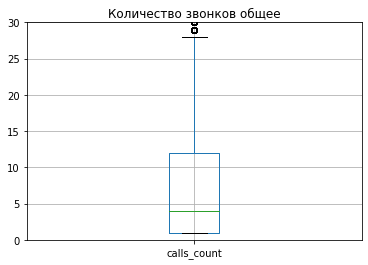

In [30]:
telecom['calls_count'].to_frame().boxplot().set_title('Количество звонков общее')
plt.ylim(0,30)

In [31]:
high_border=telecom['calls_count'].quantile(0.99)
high_border

165.0899999999965

In [32]:
telecom.query('calls_count>165 & call_duration==0 ')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag
970,166405,2019-09-27 00:00:00+03:00,in,False,166405,True,284,0,818,0
977,166405,2019-09-28 00:00:00+03:00,in,False,166405,True,263,0,342,0
983,166405,2019-09-30 00:00:00+03:00,in,False,166405,True,598,0,352,0
990,166405,2019-10-01 00:00:00+03:00,in,False,166405,True,714,0,467,0
998,166405,2019-10-02 00:00:00+03:00,in,False,166405,True,357,0,3940,0
...,...,...,...,...,...,...,...,...,...,...
48123,168361,2019-11-26 00:00:00+03:00,out,False,965544,True,200,0,4342,0
48160,168361,2019-11-27 00:00:00+03:00,in,False,168361,True,698,0,1500,0
48163,168361,2019-11-27 00:00:00+03:00,out,False,945286,True,236,0,3631,0
48204,168361,2019-11-28 00:00:00+03:00,out,False,945286,True,279,0,3983,0


267 операторов у которых большое количество звонков и все пропущенные, если со входящими звонками понятно, то непонятно, что с исходящими, все уберем как ошибочные.

In [33]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48892 entries, 0 to 48891
Data columns (total 10 columns):
user_id                48892 non-null int64
date                   48892 non-null datetime64[ns, pytz.FixedOffset(180)]
direction              48892 non-null object
internal               48892 non-null object
operator_id            48892 non-null int32
is_missed_call         48892 non-null bool
calls_count            48892 non-null int64
call_duration          48892 non-null int64
total_call_duration    48892 non-null int64
flag                   48892 non-null int64
dtypes: bool(1), datetime64[ns, pytz.FixedOffset(180)](1), int32(1), int64(5), object(2)
memory usage: 3.2+ MB


In [34]:
telecom['flag']=0
telecom.loc[(telecom['calls_count']>165)&(telecom['call_duration']==0) ,'flag'] =1

In [35]:
telecom = telecom.loc[(telecom['flag']==0)]
telecom

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag
0,166377,2019-08-04 00:00:00+03:00,in,False,166377,True,2,0,4,0
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,0
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,0
...,...,...,...,...,...,...,...,...,...,...
48887,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25,0
48888,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,0
48889,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,0
48890,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,0


Посмотрим, кто остался

In [36]:
telecom.query('calls_count>165 ')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag
5968,166582,2019-08-12 00:00:00+03:00,out,False,885890,False,181,18953,22349,0
5969,166582,2019-08-12 00:00:00+03:00,out,False,885876,False,184,20746,24152,0
5977,166582,2019-08-13 00:00:00+03:00,out,False,885890,False,308,35126,40739,0
5979,166582,2019-08-13 00:00:00+03:00,out,False,885876,False,265,30422,35448,0
5987,166582,2019-08-14 00:00:00+03:00,out,False,885876,False,170,21756,24643,0
...,...,...,...,...,...,...,...,...,...,...
47239,168361,2019-10-28 00:00:00+03:00,out,False,945278,False,169,10702,14266,0
47459,168361,2019-11-05 00:00:00+03:00,out,False,945278,False,174,10216,13896,0
47513,168361,2019-11-07 00:00:00+03:00,out,False,945286,False,184,9446,13419,0
47965,168361,2019-11-21 00:00:00+03:00,out,False,965544,False,167,21570,24141,0


Количество звонков от 166 до 1490, при условной норме на исходящие звонки -144 на оператора в день. будем считать это сбоем автомаики и тоже удалим.

In [37]:
telecom['flag']=0
telecom.loc[(telecom['calls_count']>165),'flag'] =1

In [38]:
telecom = telecom.loc[(telecom['flag']==0)]
telecom

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag
0,166377,2019-08-04 00:00:00+03:00,in,False,166377,True,2,0,4,0
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,0
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,0
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,0
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,0
...,...,...,...,...,...,...,...,...,...,...
48887,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25,0
48888,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,0
48889,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,0
48890,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,0


### Типы колл-центров

Посмотрим колл-центры по типам (будем учитывать только внешние звонки)

In [39]:
type_user=telecom.query('internal==False').groupby(['user_id','direction'])['calls_count'].count().reset_index()
type_user

,user_id,direction,calls_count
0,166377,in,110
1,166377,out,375
2,166391,in,14
3,166392,in,92
4,166399,in,20
...,...,...,...
521,168601,out,37
522,168603,in,1
523,168603,out,6
524,168606,in,4


In [40]:
type_out = type_user.query('direction=="out"')
type_out

,user_id,direction,calls_count
1,166377,out,375
6,166405,out,581
8,166406,out,243
10,166407,out,88
15,166485,out,361
...,...,...,...
509,168481,out,7
512,168500,out,1
521,168601,out,37
523,168603,out,6


In [41]:
type_in = type_user.query('direction=="in"')
type_in

,user_id,direction,calls_count
0,166377,in,110
2,166391,in,14
3,166392,in,92
4,166399,in,20
5,166405,in,351
...,...,...,...
518,168583,in,24
519,168598,in,22
520,168601,in,31
522,168603,in,1


In [42]:
type_both= type_in.merge(type_out,on='user_id',how='inner')
type_both

,user_id,direction_x,calls_count_x,direction_y,calls_count_y
0,166377,in,110,out,375
1,166405,in,351,out,581
2,166406,in,131,out,243
3,166407,in,80,out,88
4,166485,in,194,out,361
...,...,...,...,...,...
215,168481,in,10,out,7
216,168500,in,5,out,1
217,168601,in,31,out,37
218,168603,in,1,out,6


In [43]:
list_both=type_both['user_id']

In [44]:
type_out=type_out.loc[~type_out['user_id'].isin(list_both)]
type_out

,user_id,direction,calls_count


In [45]:
type_in=type_in.loc[~type_in['user_id'].isin(list_both)]
type_in

,user_id,direction,calls_count
2,166391,in,14
3,166392,in,92
4,166399,in,20
11,166428,in,86
12,166481,in,10
...,...,...,...
515,168575,in,12
516,168578,in,1
517,168579,in,38
518,168583,in,24


In [46]:
telecom['type_user']=''

In [47]:
list_in=type_in['user_id'] 

In [48]:
telecom.loc[telecom['user_id'].isin(list_both),'type_user'] = 'both'
telecom.loc[telecom['user_id'].isin(list_in),'type_user'] = 'in'

In [49]:
telecom['waiting'] = telecom['total_call_duration']-telecom['call_duration']

поищем одного потерянного

In [50]:
telecom.query('type_user==""')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag,type_user,waiting
5967,166554,2019-08-09 00:00:00+03:00,in,True,166554,True,2,0,8,0,,8


In [51]:
telecom.query('user_id==166554')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag,type_user,waiting
5967,166554,2019-08-09 00:00:00+03:00,in,True,166554,True,2,0,8,0,,8


непонятная одна запись с бывшим неопределенным оператором. Тоже придется удалить.

In [52]:
telecom = telecom.loc[(telecom['user_id']!=166554)]


Таким образом имеем 2 типа колл-центров: только 'in' и 'both' и, видимо, оценивать их надо по-разному. 

### Анализ целесообразности разработки клиентского сервиса по оценке работы операторов

посмотрим количество операторов в колл-центрах

In [53]:
both_count=telecom.query('type_user=="both"').groupby('user_id')['operator_id'].nunique().sort_values(ascending=False).reset_index()

both_count.head(20)

,user_id,operator_id
0,168187,51
1,167626,49
2,167497,31
3,168252,29
4,168062,28
5,168361,28
6,166680,22
7,166520,19
8,166658,18
9,166916,17


In [54]:
in_count=telecom.query('type_user=="in"').groupby('user_id')['operator_id'].nunique().sort_values(ascending=False).reset_index().head(10)
in_count

,user_id,operator_id
0,166837,9
1,167059,8
2,166975,7
3,167976,5
4,166879,5
5,166428,4
6,167412,4
7,166392,4
8,167506,4
9,166896,4


 Итак, имеем: из 300 активных клиентов только порядка 20 имеют штат > 10 операторов, которых реально может заинтересовать сервис определения неэффективных операторов.

Еще наблюдение. Практически у всех клиентов есть по 1 оператору, который был неопределенный (он же коллективный неопределенный).

**Заключение по разделу:** В этом разделе данные были сгруппированы по клиентам. Выяснилось, что из более чем 700 центров, активных, записи которых есть  в файле telecom,  только 307. Они были поделены на 2 категории: 'in'и 'both'. Также были получены данные о количестве операторов в каждом из них. Только у 21 клиента штат операторов от 10 чел. до 51. И, как было выяснено,во  всех колл-центрах  имеется id оператора, который, на самом деле, является сгруппированными записями по операторам с неопределенным id. 

## Определение неэффективных операторов

### Определение критерия эффективности операторов

Hет смысла высчитывать эффективность у маленьких центров, потому, что не будет статистического среднего, и просто потому, что их можно просто посчитать в Excel'е. Уберем все колл-центры, где операторов < 5 (причем, как мы уже выяснили, у всех центров имеется  1 бывший NaN -  коллективный неизвестный)

In [55]:
list_both = both_count.query('operator_id > 4')['user_id']
list_in = in_count.query('operator_id > 4')['user_id']

In [56]:
telecom_mini = telecom.loc[telecom['user_id'].isin(list_both)|telecom['user_id'].isin(list_in)]

In [57]:
telecom_mini

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag,type_user,waiting
0,166377,2019-08-04 00:00:00+03:00,in,False,166377,True,2,0,4,0,both,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,0,both,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,0,both,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,0,both,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,0,both,25
...,...,...,...,...,...,...,...,...,...,...,...,...
48481,168412,2019-11-28 00:00:00+03:00,out,True,952468,True,11,0,0,0,both,0
48482,168412,2019-11-28 00:00:00+03:00,out,False,953462,False,25,12700,13148,0,both,448
48483,168412,2019-11-28 00:00:00+03:00,in,False,953464,False,1,30,35,0,both,5
48484,168412,2019-11-28 00:00:00+03:00,out,False,952468,False,22,2488,2862,0,both,374


### Оценка работы операторов

Будем исходить из соображений, что типы  работы операторов могут отличаться в конкретном  колл-центре. Один может работать только на входящих  звонках, другой - только на исходящих. Поэтому есть предложения считать эти критерии отдельно. 
Предлагается ввести следующие критерии оценки.
- Для входящих звонков: Процент пропущенных звонков в сравнении со средними показателями по центру. Учет только по количеству без длительности. 
- Для исходящих звонков: Среднее количество звонков в сравнении со средними показателями по центру, причем исходящие пропущенные тоже считаются звонком, так как от оператора не зависит, ответит абонент или нет. Тоже учитывается только количество, в обоих случаях от оператора не зависит с какой сложностью вопроса обратился клиент.

Все соображения одинаковы для внешних и внутренних звонков.

Нами предложена автоматическая реализация этих критериев оценки. Для этого разработана функция detect_weak_operators, которая на входе принимает следующие параметры.

- staff - датафрейм-срез строк одного колл-центра по формату файла telecom 
- client - user_id клиента, чьих операторов мы оцениваем
- calls_type -тип  звонков, по которым сравниваем операторов (принимает 2 варианта: True -внутренние, False - наружные)
- q_high_miss_in - верхняя граница - процент от какой части столбца среднего количества пропущенных звонков будет считаться неэффективностью оператора (формат 0.хх, например 0.75 - это на усмотрение менеджера колл-центра)
- q_low_calls_out - нижняя граница - аналогично верхней, процент нижней границы среднего количества исходящих звонков, который можно оценить как неэффективный  (формат 0.хх (0.25)- на усмотрение менеджера)                      


In [58]:
def get_svod_col(df):
    names = ['operator_id','calls_count_in_sum','calls_miss_in_T',
                       'calls_count_out_sum','calls_miss_out_T',
                      'day_count_in','day_miss_in_T','day_count_out','day_miss_out_T']
    if df.empty: return('NO DATA')    
    if df.query('direction=="out"').empty:
        names.remove('calls_count_out_sum')
        names.remove('calls_miss_out_T')
        names.remove('day_count_out')
        names.remove('day_miss_out_T')
        if df.query('direction=="in" & is_missed_call').empty:
            names.remove('calls_miss_in_T')
            names.remove('day_miss_in_T')                
        if df.query('direction=="in" & is_missed_call==False').empty:
            names.remove('calls_count_in_sum') 
            namess.remove('day_count_in')      
        return(names)        
    if df.query('direction=="in"').empty: 
        names.remove('calls_count_in_sum')
        names.remove('calls_miss_in_T')
        names.remove('day_count_in')
        names.remove('day_miss_in_T')
        if df.query('direction=="out" & is_missed_call').empty:
            names.remove('calls_miss_out_T')
            names.remove('day_miss_out_T') 
        if df.query('direction=="out" & is_missed_call==False').empty:
            names.remove('calls_count_out_sum')
            names.remove('day_count_out')
        return(names)    
    if df.query('direction=="out" & is_missed_call').empty:
        names.remove('calls_miss_out_T')
        names.remove('day_miss_out_T')     
    if df.query('direction=="in" & is_missed_call').empty:
        names.remove('calls_miss_in_T')
        names.remove('day_miss_in_T')                
    if df.query('direction=="in" & is_missed_call==False').empty:
        names.remove('calls_count_in_sum') 
        names.remove('day_count_in') 
    if df.query('direction=="out" & is_missed_call==False').empty:
        names.remove('calls_count_out_sum')
        names.remove('day_count_out') 
    return(names)
                         
            

In [59]:
def detect_weak_operators(staff,client,calls_type,
                          q_high_miss_in,q_low_calls_out):
                          
   

    weak_staff1=pd.DataFrame()
    weak_staff2=pd.DataFrame()
    svod_staff= pd.DataFrame()
    
    k1=0
    k2=0
    
    staff=staff.query('internal==@calls_type')
    cols = get_svod_col(staff)
    
    print('Клиент',str(client))
    #формируем свод по Колл-центру                   
    svod_staff=staff.pivot_table(index= 'operator_id',
                 columns=['direction','is_missed_call'],
                 values=['calls_count','date'],
                 aggfunc=({'calls_count':'sum','date':'count'})).reset_index().fillna(0)
    
    if get_svod_col(staff)=='NO DATA': return print('NO DATA')
    else: 
        svod_staff.columns=cols
         
        svod_staff['operator_id'] = svod_staff['operator_id'].astype(int)                                                                        
                             
    
    if not staff.query('direction=="in"').empty:
        #Вычисляем границы для колл-центра
        group_out = staff.query('direction=="in"').groupby(['operator_id'])['calls_count','is_missed_call'].sum() 
        group_out['%%'] = group_out['is_missed_call']/(group_out['calls_count']+group_out['is_missed_call'])
        miss_percent =group_out['%%']
        #много пропущенных звонков
        high_miss_count = miss_percent.quantile(q_high_miss_in)
        print('Много пропущенных звонков у операторов') 
        #Сверяем каждого оператора колл-центра с заданными критериями
        for index, row in svod_staff.iterrows():
            if 'calls_count_in_sum' in cols:
                s1 = row['calls_count_in_sum']
            else: s1=0  
            if 'calls_miss_in_T' in cols:    
                s2 = row['calls_miss_in_T']
            else: s2=0
                
        
            if (s1 == 0) & (s2 == 0):  print(row['operator_id'],'нет входящих звонков') 
            else:
                k1=s2/(s1+s2)
                                              
            if k1 > high_miss_count:
                print('missed calls:',row['operator_id'],':  max %:',round(high_miss_count,2),',  факт %:',round(k1,2))
                weak_staff1= weak_staff1.append(row,ignore_index=True)
    print()        
    if not staff.query('direction=="out"').empty:
        #Вычисляем границы для колл-центра
        mean_callsm_out = staff.query('direction=="out"').groupby(['operator_id','date']).agg({'calls_count':['sum','count']})
        mean_callsm_out.columns=['sum','count']
        mean_callsm_out=mean_callsm_out.groupby('operator_id')['sum','count'].sum()
        mean_callsm_out['mean']= mean_callsm_out['sum']/mean_callsm_out['count']                                                       
        #мало исходящих звонков
        low_calls_count = mean_callsm_out['mean'].quantile(q_low_calls_out)
        print('Мало исходящих звонков у операторов')
        #Сверяем каждого оператора колл-центра с заданными критериями
        for index, row in svod_staff.iterrows():                               
            if 'calls_count_out_sum' in cols:
                s3=row['calls_count_out_sum']
            else:s3=0   
            if 'calls_miss_out_T' in cols:
                s4=row['calls_miss_out_T']
            else: s4=0  
            if (s3==0)&(s4==0): print(row['operator_id'],'нет исходящих звонков')
            else:    
                if 'day_count_out' in cols:
                    d1=row['day_count_out']
                else: d1=0    
                if 'day_miss_out_T' in cols:
                    d2=row['day_miss_out_T']
                else: d2=0   
              
                k2 = (s3+s4)/(d1+d2)
                
                if k2 < low_calls_count :
                    print('mean out-calls:',row['operator_id'],'min N:',round(low_calls_count,2),'факт N:',round(k2,2))
                    weak_staff2= weak_staff2.append(row,ignore_index=True)
    print( len(weak_staff1),len(weak_staff2))            
    #return(weak_staff1,weak_staff2)
    print('=============================')
    

Имеем 2 списка клиентов по их типам:list_both и list_in.Чтобы определить всех неэффективных операторов рассчитаем их в цикле. 
Возможны 4 группы расчета по типам колл-центра (in,both) и по типам звонков(internal)

In [60]:
for user in list_both:
    staff=telecom_mini.query('user_id == @user')
    detect_weak_operators(staff,user,False,0.75,0.25)

Клиент 168187
Много пропущенных звонков у операторов
missed calls: 168187.0 :  max %: 0.02 ,  факт %: 1.0
937716.0 нет входящих звонков
missed calls: 937732.0 :  max %: 0.02 ,  факт %: 0.02
missed calls: 937750.0 :  max %: 0.02 ,  факт %: 0.02
937770.0 нет входящих звонков
937772.0 нет входящих звонков
937778.0 нет входящих звонков
937786.0 нет входящих звонков
missed calls: 937860.0 :  max %: 0.02 ,  факт %: 0.02
missed calls: 937864.0 :  max %: 0.02 ,  факт %: 0.02
missed calls: 937868.0 :  max %: 0.02 ,  факт %: 0.02
937870.0 нет входящих звонков
missed calls: 937870.0 :  max %: 0.02 ,  факт %: 0.02
937872.0 нет входящих звонков
missed calls: 937872.0 :  max %: 0.02 ,  факт %: 0.02
missed calls: 937874.0 :  max %: 0.02 ,  факт %: 0.06
missed calls: 937898.0 :  max %: 0.02 ,  факт %: 0.22
937900.0 нет входящих звонков
missed calls: 937900.0 :  max %: 0.02 ,  факт %: 0.22
missed calls: 937956.0 :  max %: 0.02 ,  факт %: 0.03
missed calls: 937958.0 :  max %: 0.02 ,  факт %: 0.03
missed

Много пропущенных звонков у операторов
missed calls: 168062.0 :  max %: 0.01 ,  факт %: 1.0
947590.0 нет входящих звонков
missed calls: 947590.0 :  max %: 0.01 ,  факт %: 1.0
947592.0 нет входящих звонков
missed calls: 947592.0 :  max %: 0.01 ,  факт %: 1.0
947596.0 нет входящих звонков
missed calls: 947596.0 :  max %: 0.01 ,  факт %: 1.0
947598.0 нет входящих звонков
missed calls: 947598.0 :  max %: 0.01 ,  факт %: 1.0
947600.0 нет входящих звонков
missed calls: 947600.0 :  max %: 0.01 ,  факт %: 1.0
947614.0 нет входящих звонков
947616.0 нет входящих звонков
947618.0 нет входящих звонков
947620.0 нет входящих звонков
947636.0 нет входящих звонков
947638.0 нет входящих звонков
947640.0 нет входящих звонков
947642.0 нет входящих звонков
947644.0 нет входящих звонков
947646.0 нет входящих звонков
947648.0 нет входящих звонков
947650.0 нет входящих звонков
947652.0 нет входящих звонков
947654.0 нет входящих звонков
947658.0 нет входящих звонков
missed calls: 951508.0 :  max %: 0.01 ,  фа

Мало исходящих звонков у операторов
167580.0 нет исходящих звонков
mean out-calls: 937362.0 min N: 1.22 факт N: 1.0
mean out-calls: 937366.0 min N: 1.22 факт N: 1.0
mean out-calls: 937368.0 min N: 1.22 факт N: 1.0
937370.0 нет исходящих звонков
937374.0 нет исходящих звонков
2 3
Клиент 167176
Много пропущенных звонков у операторов
missed calls: 167176.0 :  max %: 0.02 ,  факт %: 1.0
missed calls: 904344.0 :  max %: 0.02 ,  факт %: 0.75
missed calls: 905104.0 :  max %: 0.02 ,  факт %: 0.03
missed calls: 907952.0 :  max %: 0.02 ,  факт %: 0.04

Мало исходящих звонков у операторов
167176.0 нет исходящих звонков
904344.0 нет исходящих звонков
904372.0 нет исходящих звонков
905472.0 нет исходящих звонков
905478.0 нет исходящих звонков
907952.0 нет исходящих звонков
907986.0 нет исходящих звонков
907994.0 нет исходящих звонков
4 0
Клиент 167188
Много пропущенных звонков у операторов
missed calls: 167188.0 :  max %: 0.0 ,  факт %: 1.0
914238.0 нет входящих звонков
914338.0 нет входящих звонко

Много пропущенных звонков у операторов
missed calls: 168225.0 :  max %: 0.0 ,  факт %: 1.0
970242.0 нет входящих звонков
970250.0 нет входящих звонков
970258.0 нет входящих звонков

Мало исходящих звонков у операторов
168225.0 нет исходящих звонков
1 0
Клиент 167109
Много пропущенных звонков у операторов
missed calls: 167109.0 :  max %: 0.0 ,  факт %: 1.0
missed calls: 906294.0 :  max %: 0.0 ,  факт %: 0.0
907180.0 нет входящих звонков
909910.0 нет входящих звонков

Мало исходящих звонков у операторов
167109.0 нет исходящих звонков
mean out-calls: 906296.0 min N: 2.07 факт N: 2.0
mean out-calls: 907182.0 min N: 2.07 факт N: 1.75
2 2
Клиент 166901
Много пропущенных звонков у операторов
missed calls: 166901.0 :  max %: 0.0 ,  факт %: 1.0
missed calls: 896012.0 :  max %: 0.0 ,  факт %: 0.0

Мало исходящих звонков у операторов
166901.0 нет исходящих звонков
mean out-calls: 896010.0 min N: 1.38 факт N: 1.0
896012.0 нет исходящих звонков
896020.0 нет исходящих звонков
2 1
Клиент 167172
Много

Много пропущенных звонков у операторов
missed calls: 166609.0 :  max %: 0.18 ,  факт %: 1.0
887992.0 нет входящих звонков
892800.0 нет входящих звонков
895370.0 нет входящих звонков

Мало исходящих звонков у операторов
166609.0 нет исходящих звонков
mean out-calls: 892800.0 min N: 3.06 факт N: 2.67
1 1
Клиент 166377
Много пропущенных звонков у операторов
missed calls: 166377.0 :  max %: 0.0 ,  факт %: 1.0
881278.0 нет входящих звонков

Мало исходящих звонков у операторов
mean out-calls: 166377.0 min N: 2.61 факт N: 1.0
mean out-calls: 881278.0 min N: 2.61 факт N: 2.4
1 2
Клиент 166941
Много пропущенных звонков у операторов
missed calls: 166941.0 :  max %: 0.06 ,  факт %: 1.0
896384.0 нет входящих звонков
896386.0 нет входящих звонков
896390.0 нет входящих звонков

Мало исходящих звонков у операторов
166941.0 нет исходящих звонков
mean out-calls: 896708.0 min N: 9.33 факт N: 6.61
1 1
Клиент 167977
Много пропущенных звонков у операторов
missed calls: 167977.0 :  max %: 0.07 ,  факт %: 1.

Клиент 167175
Много пропущенных звонков у операторов
missed calls: 167175.0 :  max %: 0.2 ,  факт %: 1.0
905840.0 нет входящих звонков
missed calls: 905840.0 :  max %: 0.2 ,  факт %: 1.0
938842.0 нет входящих звонков

Мало исходящих звонков у операторов
167175.0 нет исходящих звонков
mean out-calls: 905840.0 min N: 5.92 факт N: 1.17
2 1
Клиент 167819
Много пропущенных звонков у операторов
missed calls: 167819.0 :  max %: 0.06 ,  факт %: 0.92
missed calls: 927912.0 :  max %: 0.06 ,  факт %: 0.06

Мало исходящих звонков у операторов
167819.0 нет исходящих звонков
927908.0 нет исходящих звонков
927910.0 нет исходящих звонков
927912.0 нет исходящих звонков
2 0
Клиент 166541
Много пропущенных звонков у операторов
missed calls: 166541.0 :  max %: 0.01 ,  факт %: 1.0
missed calls: 908960.0 :  max %: 0.01 ,  факт %: 0.02

Мало исходящих звонков у операторов
910958.0 нет исходящих звонков
2 0
Клиент 167947
Много пропущенных звонков у операторов
missed calls: 167947.0 :  max %: 0.18 ,  факт %: 1

In [61]:
for user in list_in:
    staff=telecom_mini.query('user_id == @user')
    detect_weak_operators(staff,user,False,0.75,0.25)

Клиент 166837
Много пропущенных звонков у операторов
missed calls: 166837.0 :  max %: 0.2 ,  факт %: 1.0
missed calls: 910226.0 :  max %: 0.2 ,  факт %: 0.25
missed calls: 913886.0 :  max %: 0.2 ,  факт %: 0.5
missed calls: 930242.0 :  max %: 0.2 ,  факт %: 0.25

4 0
Клиент 167059
Много пропущенных звонков у операторов
missed calls: 167059.0 :  max %: 0.09 ,  факт %: 1.0
missed calls: 911102.0 :  max %: 0.09 ,  факт %: 0.11
missed calls: 911142.0 :  max %: 0.09 ,  факт %: 0.1

3 0
Клиент 166975
Много пропущенных звонков у операторов
missed calls: 166975.0 :  max %: 0.03 ,  факт %: 1.0
missed calls: 899268.0 :  max %: 0.03 ,  факт %: 0.06

2 0
Клиент 167976
Много пропущенных звонков у операторов
missed calls: 167976.0 :  max %: 0.03 ,  факт %: 1.0
missed calls: 934430.0 :  max %: 0.03 ,  факт %: 0.04

2 0
Клиент 166879
Много пропущенных звонков у операторов
missed calls: 166879.0 :  max %: 0.07 ,  факт %: 1.0
missed calls: 896538.0 :  max %: 0.07 ,  факт %: 0.07

2 0


In [62]:
for user in list_both:
    staff=telecom_mini.query('user_id == @user')
    detect_weak_operators(staff,user,True,0.75,0.25)

Клиент 168187
Много пропущенных звонков у операторов
missed calls: 168187.0 :  max %: 0.0 ,  факт %: 1.0
937710.0 нет входящих звонков
937720.0 нет входящих звонков
missed calls: 937780.0 :  max %: 0.0 ,  факт %: 0.06
937898.0 нет входящих звонков
missed calls: 937962.0 :  max %: 0.0 ,  факт %: 0.14

Мало исходящих звонков у операторов
168187.0 нет исходящих звонков
937708.0 нет исходящих звонков
937732.0 нет исходящих звонков
937742.0 нет исходящих звонков
937750.0 нет исходящих звонков
937760.0 нет исходящих звонков
937788.0 нет исходящих звонков
937812.0 нет исходящих звонков
937856.0 нет исходящих звонков
937860.0 нет исходящих звонков
937862.0 нет исходящих звонков
937868.0 нет исходящих звонков
937874.0 нет исходящих звонков
937880.0 нет исходящих звонков
937888.0 нет исходящих звонков
937902.0 нет исходящих звонков
937956.0 нет исходящих звонков
937958.0 нет исходящих звонков
937960.0 нет исходящих звонков
937962.0 нет исходящих звонков
937988.0 нет исходящих звонков
946072.0 не

Мало исходящих звонков у операторов
mean out-calls: 167176.0 min N: 2.0 факт N: 1.0
mean out-calls: 905480.0 min N: 2.0 факт N: 1.0
mean out-calls: 907982.0 min N: 2.0 факт N: 1.88
0 3
Клиент 167188
Много пропущенных звонков у операторов
missed calls: 167188.0 :  max %: 0.0 ,  факт %: 1.0
914238.0 нет входящих звонков
914338.0 нет входящих звонков
957022.0 нет входящих звонков
964716.0 нет входящих звонков

Мало исходящих звонков у операторов
mean out-calls: 167188.0 min N: 1.67 факт N: 1.0
908130.0 нет исходящих звонков
908152.0 нет исходящих звонков
908180.0 нет исходящих звонков
908300.0 нет исходящих звонков
923646.0 нет исходящих звонков
962168.0 нет исходящих звонков
1 1
Клиент 168336
Много пропущенных звонков у операторов
missed calls: 168336.0 :  max %: 0.12 ,  факт %: 1.0
947304.0 нет входящих звонков
missed calls: 947304.0 :  max %: 0.12 ,  факт %: 1.0
948756.0 нет входящих звонков
missed calls: 948756.0 :  max %: 0.12 ,  факт %: 1.0
948758.0 нет входящих звонков
missed calls

Мало исходящих звонков у операторов
167475.0 нет исходящих звонков
1 0
Клиент 167436
Много пропущенных звонков у операторов
missed calls: 167436.0 :  max %: 0.23 ,  факт %: 1.0
914266.0 нет входящих звонков
missed calls: 914266.0 :  max %: 0.23 ,  факт %: 1.0
939886.0 нет входящих звонков
missed calls: 939886.0 :  max %: 0.23 ,  факт %: 1.0
961552.0 нет входящих звонков
missed calls: 961552.0 :  max %: 0.23 ,  факт %: 1.0

Мало исходящих звонков у операторов
167436.0 нет исходящих звонков
mean out-calls: 914266.0 min N: 2.3 факт N: 2.0
4 1
Клиент 166843
Много пропущенных звонков у операторов
missed calls: 166843.0 :  max %: 0.5 ,  факт %: 1.0
895172.0 нет входящих звонков
missed calls: 895172.0 :  max %: 0.5 ,  факт %: 1.0
913868.0 нет входящих звонков
missed calls: 913868.0 :  max %: 0.5 ,  факт %: 1.0
926312.0 нет входящих звонков
missed calls: 926312.0 :  max %: 0.5 ,  факт %: 1.0

Мало исходящих звонков у операторов
166843.0 нет исходящих звонков
4 0
Клиент 166732
Много пропущенных

In [63]:
for user in list_in:
    staff=telecom_mini.query('user_id == @user')
    detect_weak_operators(staff,user,True,0.75,0.25)                                                   

Клиент 166837
NO DATA
Клиент 167059
NO DATA
Клиент 166975
Много пропущенных звонков у операторов
missed calls: 166975.0 :  max %: 0.17 ,  факт %: 1.0

1 0
Клиент 167976
NO DATA
Клиент 166879
Много пропущенных звонков у операторов
missed calls: 166879.0 :  max %: 0.04 ,  факт %: 1.0

1 0


!Прошу обратить внимание: если в полученных списках есть id оператора, совпадающего с id колл-центра, это значит, что это сгруппированные записи всех неопределенных операторов колл-центра. 

**Заключение по разделу:**  В этом разделе были предложены критерии оценки операторов. Реализован алгоритм в виде программы для автоматического расчета эффективности штата операторов колл-центра и проведен расчет с выдачей в текстовом варианте списка наименее эффективных операторов по каждому колл-центру.  

## Проверка гипотез

### Гипотеза 1

Гипотеза1: У колл-центров с разными тарифами не отличается время дозвона.Гипотеза двухсторонняя.
Альтернативная: время дозвона зависит от тарифа клиента.

Подготовим данные для статистической оценки. Добавим сведения о тарифах в основной файл.

In [64]:
clients['tariff_plan'].value_counts()

C    395
B    261
A     76
Name: tariff_plan, dtype: int64

In [65]:
telecom= telecom.merge(clients,on='user_id')
telecom

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag,type_user,waiting,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,166377,True,2,0,4,0,both,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,0,both,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,0,both,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,0,both,8,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,0,both,25,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48397,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25,0,both,25,C,2019-10-31
48398,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38,0,both,38,C,2019-10-31
48399,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501,0,both,22,C,2019-10-31
48400,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190,0,both,60,C,2019-10-31


Сделаем выборку-срез по внешним входящим принятым звонкам

In [66]:
telecom_abc = telecom.query('internal== False & direction=="in" & calls_count > 0')
telecom_abc

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag,type_user,waiting,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,166377,True,2,0,4,0,both,4,B,2019-08-01
7,166377,2019-08-05 00:00:00+03:00,in,False,166377,True,6,0,35,0,both,35,B,2019-08-01
8,166377,2019-08-06 00:00:00+03:00,in,False,166377,True,4,0,62,0,both,62,B,2019-08-01
16,166377,2019-08-07 00:00:00+03:00,in,False,166377,True,2,0,24,0,both,24,B,2019-08-01
25,166377,2019-08-12 00:00:00+03:00,in,False,880028,False,1,407,411,0,both,4,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48390,168603,2019-11-28 00:00:00+03:00,in,False,168603,True,1,0,30,0,both,30,B,2019-10-31
48392,168606,2019-11-08 00:00:00+03:00,in,False,957922,True,1,0,7,0,both,7,C,2019-10-31
48394,168606,2019-11-08 00:00:00+03:00,in,False,168606,True,6,0,121,0,both,121,C,2019-10-31
48395,168606,2019-11-08 00:00:00+03:00,in,False,957922,False,2,686,705,0,both,19,C,2019-10-31


Добавим среднее ожидание

In [67]:
telecom_abc['mean_wait'] = telecom_abc['waiting']/telecom_abc['calls_count']
telecom_abc.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag,type_user,waiting,tariff_plan,date_start,mean_wait
0,166377,2019-08-04 00:00:00+03:00,in,False,166377,True,2,0,4,0,both,4,B,2019-08-01,2.000000
7,166377,2019-08-05 00:00:00+03:00,in,False,166377,True,6,0,35,0,both,35,B,2019-08-01,5.833333
8,166377,2019-08-06 00:00:00+03:00,in,False,166377,True,4,0,62,0,both,62,B,2019-08-01,15.500000
16,166377,2019-08-07 00:00:00+03:00,in,False,166377,True,2,0,24,0,both,24,B,2019-08-01,12.000000
25,166377,2019-08-12 00:00:00+03:00,in,False,880028,False,1,407,411,0,both,4,B,2019-08-01,4.000000


In [68]:
a = telecom_abc.query('tariff_plan == "A"')['mean_wait']
b = telecom_abc.query('tariff_plan == "B"')['mean_wait']
c = telecom_abc.query('tariff_plan == "C"')['mean_wait']


In [69]:
result_ab=st.ttest_ind(a,b,equal_var=False  )
result_ab

Ttest_indResult(statistic=-8.286461647219156, pvalue=1.3107800053788635e-16)

In [70]:
result_ac=st.ttest_ind(a,c,equal_var=False)
result_ac

Ttest_indResult(statistic=-4.774830720862444, pvalue=1.8277286350799628e-06)

In [71]:
result_bc=st.ttest_ind(b,c,equal_var=False)
result_bc

Ttest_indResult(statistic=4.657599737590294, pvalue=3.231107092613226e-06)

In [72]:
print('result_ab=',round(result_ab.pvalue,5),'result_ac=',round(result_ac.pvalue,5),'result_bc=',round(result_bc.pvalue,5))

result_ab= 0.0 result_ac= 0.0 result_bc= 0.0


Если сравнить полученные значения pvalue, то все они меньше условно-стандартного alpha = 0.05. Значит отвергаем нулевую гипотезу. Поэтому, скорее всего, у тарифов есть свои плюшки, от которых зависит скорость дозвона.

### Гипотеза 2

Гипотеза2: Средняя продолжительность внутренних разговоров одинакова в "in" и "both" колл-центрах.

Альтернативная: Средняя продолжительность внутренних разговоров зависит от специфики центра.

In [73]:
test = telecom.query(' direction == "in" & call_duration > 0 ')
test

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag,type_user,waiting,tariff_plan,date_start
25,166377,2019-08-12 00:00:00+03:00,in,False,880028,False,1,407,411,0,both,4,B,2019-08-01
32,166377,2019-08-13 00:00:00+03:00,in,False,880028,False,1,88,102,0,both,14,B,2019-08-01
35,166377,2019-08-14 00:00:00+03:00,in,False,880026,False,2,197,218,0,both,21,B,2019-08-01
37,166377,2019-08-14 00:00:00+03:00,in,False,880028,False,1,33,37,0,both,4,B,2019-08-01
45,166377,2019-08-15 00:00:00+03:00,in,False,880028,False,1,23,27,0,both,4,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48368,168601,2019-11-22 00:00:00+03:00,in,False,952914,False,2,429,442,0,both,13,C,2019-10-31
48373,168601,2019-11-25 00:00:00+03:00,in,False,952914,False,7,1229,1282,0,both,53,C,2019-10-31
48376,168601,2019-11-26 00:00:00+03:00,in,False,952914,False,4,539,562,0,both,23,C,2019-10-31
48379,168601,2019-11-27 00:00:00+03:00,in,False,952914,False,2,53,77,0,both,24,C,2019-10-31


In [74]:
test['mean_duration'] = test['call_duration']/test['calls_count']
test


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,flag,type_user,waiting,tariff_plan,date_start,mean_duration
25,166377,2019-08-12 00:00:00+03:00,in,False,880028,False,1,407,411,0,both,4,B,2019-08-01,407.000000
32,166377,2019-08-13 00:00:00+03:00,in,False,880028,False,1,88,102,0,both,14,B,2019-08-01,88.000000
35,166377,2019-08-14 00:00:00+03:00,in,False,880026,False,2,197,218,0,both,21,B,2019-08-01,98.500000
37,166377,2019-08-14 00:00:00+03:00,in,False,880028,False,1,33,37,0,both,4,B,2019-08-01,33.000000
45,166377,2019-08-15 00:00:00+03:00,in,False,880028,False,1,23,27,0,both,4,B,2019-08-01,23.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48368,168601,2019-11-22 00:00:00+03:00,in,False,952914,False,2,429,442,0,both,13,C,2019-10-31,214.500000
48373,168601,2019-11-25 00:00:00+03:00,in,False,952914,False,7,1229,1282,0,both,53,C,2019-10-31,175.571429
48376,168601,2019-11-26 00:00:00+03:00,in,False,952914,False,4,539,562,0,both,23,C,2019-10-31,134.750000
48379,168601,2019-11-27 00:00:00+03:00,in,False,952914,False,2,53,77,0,both,24,C,2019-10-31,26.500000


In [75]:
test_in= test.query('type_user=="in"')['mean_duration']
test_in

519      175.0
521        5.5
522       57.0
532        4.0
538       13.0
         ...  
48308     16.0
48309     15.0
48310    527.0
48312     44.5
48313    188.0
Name: mean_duration, Length: 1550, dtype: float64

In [76]:
test_both= test.query('type_user=="both"')['mean_duration']
test_both

25       407.000000
32        88.000000
35        98.500000
37        33.000000
45        23.000000
            ...    
48368    214.500000
48373    175.571429
48376    134.750000
48379     26.500000
48395    343.000000
Name: mean_duration, Length: 10768, dtype: float64

In [77]:
result=st.ttest_ind(test_both,test_in,equal_var=False)
result

Ttest_indResult(statistic=1.6210505500065038, pvalue=0.10516938770824019)

In [78]:
print('result=',round(result.pvalue,5))

result= 0.10517


Не получилось отвергнуть нулевую гипотезу.10.5% - это достаточно большая вероятность, чтобы говорить о значимом различии длительности разговора.

И просто статистика: 


In [79]:
telecom.groupby(['tariff_plan'])['user_id'].nunique()

tariff_plan
A     34
B    111
C    161
Name: user_id, dtype: int64

**Заключение по разделу** В этом разделе были сформулированы и проверены на статистическую значимость 2 гипотезы.

## Выводы и рекомендации

- Целью данного исследования является определение критериев неэффективности операторов и согласно этим критериям выявление неэффективных операторов.
- Для подготовки данных к исследованию в предоставленном файле были удалены двойные записи, удалены явно ошибочные записи, частично удалены записи с неопределенными значениями, другие - в случае с неопределенным operator_id - заменены на id колл-центра. Таким образом в каждом колл-центре образовалось по одному дополнительному мега-оператору, вобравшему в себя все неопределенные записи, что, конечно, не может не искажать результаты центра.
- После произведенных манипуляций в файле осталось 306 колл-центров, которым были присвоены условные типы "in", которые имеют только входящие внешние звонки, и "both" у которых звонки in и out, 86 и 220 соответственно. Предполагалось, что оценивать их надо будет по-разному.
- Для оценки эффективности мы решили взять, по устоявшейся практике оценки, только количество входящих и исходящих звонков, определяя эффективность с  учетом средних показателей конкретного центра. Нами был разработан и реализован алгоритм автоматического выявления неэффективных операторов центра, на вход требуется только выборка-срез данных по конкретному центру по формату  предоставленого менеджерами файла telecom, причем критерии эффективности (% порога отсева) может задавать менеджер при расчете.
- В процессе исследования выяснилось, что только у порядка 20 колл-центров штат операторов превышает 10 человек. Мы пришли к заключению, что нет большого смысла автоматически рассчитывать эффективность в маленьких колл-центрах, поэтому отобрали клиентов со штатом от 5 человек. Таковых оказалось 86 центров.(но программа будет работать для любого количества операторов)
- По этим центрам был произведен расчет по 4-ем вариантам (внешние и внутренние звонки, "in" и "both" типы центров). 
- Далее были проверены 2 гипотезы на статистическую значимость.
- В качестве рекомендации могу предложить тщательнее готовить файл для анализа, а в результатах расчета по этому файлу иметь в виду, что id_operator, совпадающий с id колл-центра, является сборным и искажает объективную кактину. 

## Блок презентации

- Презентацию можно посмотреть по ссылке:
https://drive.google.com/file/d/1XTG0qMXlleQOCb33tpKiOlA4A-k1f_kb/view?usp=sharing


- Дашборд
https://public.tableau.com/app/profile/irina8639/viz/Book2_16374488118970/Dashboard1?publish=yes